In [1]:
!pip install -q polars pandas joblib scikit-learn xgboost pyarrow matplotlib numpy --upgrade

In [2]:
from pathlib import Path
import polars as pl
from pyarrow import dataset as ds

# ==============================
# Config
# ==============================
DATA_DIR = Path("data/backblaze")
SINGLE_PARQUET = Path("hdd_full_clean.parquet")
PARTITION_DIR = Path("hdd_parquet_by_year")
PARTITION_DIR.mkdir(parents=True, exist_ok=True)

KEEP_COLS = [
    "date", "serial_number", "model", "failure",
    "smart_5_raw", "smart_9_raw", "smart_187_raw",
    "smart_194_raw", "smart_197_raw", "smart_198_raw",
]
SMART_COLS = [c for c in KEEP_COLS if c.startswith("smart_")]

# ==============================
# Discover CSVs
# ==============================
csv_files = sorted(DATA_DIR.glob("**/*.csv"))
print(f"Found {len(csv_files)} CSV files.")
if not csv_files:
    raise SystemExit("No CSVs found under data/backblaze. Check the path.")

# ==============================
# Build lazy scans (schema-drift tolerant)
# ==============================
lazy_frames = []
print("Scanning individual files...")
for file in csv_files:
    try:
        # Fast header-only schema to see available columns
        available_cols = pl.scan_csv(file, n_rows=0).collect_schema().names()
        select_cols = [c for c in KEEP_COLS if c in available_cols]
        if not select_cols:
            continue

        lf = (
            pl.scan_csv(
                file,
                infer_schema_length=0,   # fast header inference
                ignore_errors=True       # tolerate row-level issues
            )
            .select(select_cols)
        )
        lazy_frames.append(lf)
    except Exception as e:
        print(f"⚠️ Could not process file: {file}. Error: {e}")

if not lazy_frames:
    raise SystemExit("No frames could be built from CSVs with the requested columns.")

# ==============================
# Concatenate & clean (still lazy)
# ==============================
print("Combining all files (lazy concat)...")
lf = pl.concat(lazy_frames, how="diagonal", rechunk=True)

# Inspect schema cheaply
existing_cols = set(lf.collect_schema().names())

def smart_expr(col: str) -> pl.Expr:
    """Cast SMART column to Int64 if present; otherwise create zero-filled column."""
    if col in existing_cols:
        return pl.col(col).cast(pl.Int64, strict=False).fill_null(0).alias(col)
    return pl.lit(0, dtype=pl.Int64).alias(col)

lf = (
    lf.with_columns([
        # Robust date parsing (non-strict; set to strict=True if you want failures)
        pl.col("date").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
        # Failure to tiny int; null -> 0
        pl.col("failure").cast(pl.Int8, strict=False).fill_null(0),
        # All SMART cols at once (for present columns), zero-fill when missing
        *[smart_expr(c) for c in SMART_COLS],
    ])
    .with_columns(pl.col("date").dt.year().alias("year"))
)

# ==============================
# Execute plan & write outputs
# ==============================
print("Executing the lazy plan (streaming engine)...")
df = lf.collect(engine="streaming")

print(f"Writing single Parquet -> {SINGLE_PARQUET}")
df.write_parquet(
    SINGLE_PARQUET,
    compression="zstd",
    use_pyarrow=True,
    statistics=True
)

print(f"Writing partitioned Parquet dataset -> {PARTITION_DIR}/year=YYYY/...")
table = df.to_arrow()
ds.write_dataset(
    table,
    base_dir=str(PARTITION_DIR),
    format="parquet",
    partitioning=["year"],
    existing_data_behavior="overwrite_or_ignore",
    file_options=ds.ParquetFileFormat().make_write_options(compression="zstd"),
)

# ==============================
# Quick stats
# ==============================
n_rows = df.height
n_fail = int(df.select(pl.col("failure").sum()).item())
date_min, date_max = (
    df.select(
        pl.col("date").min().alias("date_min"),
        pl.col("date").max().alias("date_max"),
    ).row(0)
)
models = df.select(pl.col("model").n_unique().alias("unique_models")).item()

print(f"✅ Rows: {n_rows:,}")
print(f"✅ Failures: {n_fail}")
print(f"✅ Date range: {date_min} → {date_max}")
print(f"✅ Unique models: {models}")
print("Done.")

Found 1072 CSV files.
Scanning individual files...
Combining all files (lazy concat)...
Executing the lazy plan (streaming engine)...
Writing single Parquet -> hdd_full_clean.parquet
Writing partitioned Parquet dataset -> hdd_parquet_by_year/year=YYYY/...
✅ Rows: 193,599,527
✅ Failures: 6508
✅ Date range: 2020-01-01 → 2022-12-31
✅ Unique models: 80
Done.


In [3]:
df.head()

date,serial_number,model,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_194_raw,smart_197_raw,smart_198_raw,year
date,str,str,i8,i64,i64,i64,i64,i64,i64,i32
2020-01-01,"""Z305B2QN""","""ST4000DM000""",0,0,35462,0,22,0,0,2020
2020-01-01,"""ZJV0XJQ4""","""ST12000NM0007""",0,0,12494,0,28,0,0,2020
2020-01-01,"""ZJV0XJQ3""","""ST12000NM0007""",0,0,9544,0,29,0,0,2020
2020-01-01,"""ZJV0XJQ0""","""ST12000NM0007""",0,0,13098,0,25,0,0,2020
2020-01-01,"""PL1331LAHG1S4H""","""HGST HMS5C4040ALE640""",0,0,25546,0,28,0,0,2020


In [4]:
df.tail()

date,serial_number,model,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_194_raw,smart_197_raw,smart_198_raw,year
date,str,str,i8,i64,i64,i64,i64,i64,i64,i32
2022-12-31,"""3WJRXE8K""","""WDC WUH721816ALE6L4""",0,0,1316,0,30,0,0,2022
2022-12-31,"""3WJXK5YK""","""WDC WUH721816ALE6L4""",0,0,1321,0,33,0,0,2022
2022-12-31,"""3WJZY4EJ""","""WDC WUH721816ALE6L4""",0,0,1317,0,29,0,0,2022
2022-12-31,"""3WK6NENK""","""WDC WUH721816ALE6L4""",0,0,1323,0,34,0,0,2022
2022-12-31,"""3WKWSKHK""","""WDC WUH721816ALE6L4""",0,0,1308,0,38,0,0,2022


=== Logistic Regression ===
=== Random Forest ===
=== XGBoost ===
=== Stacking Classifier ===

--- Model Performance Summary ---
shape: (4, 4)
┌─────────────────────┬──────────┬──────────┬───────────┐
│ Model               ┆ F2-Score ┆ Recall   ┆ Precision │
│ ---                 ┆ ---      ┆ ---      ┆ ---       │
│ str                 ┆ f64      ┆ f64      ┆ f64       │
╞═════════════════════╪══════════╪══════════╪═══════════╡
│ XGBoost             ┆ 0.690872 ┆ 0.769861 ┆ 0.489838  │
│ Stacking Classifier ┆ 0.667802 ┆ 0.642097 ┆ 0.795132  │
│ Random Forest       ┆ 0.573944 ┆ 0.533989 ┆ 0.819095  │
│ Logistic Regression ┆ 0.393496 ┆ 0.519247 ┆ 0.199874  │
└─────────────────────┴──────────┴──────────┴───────────┘


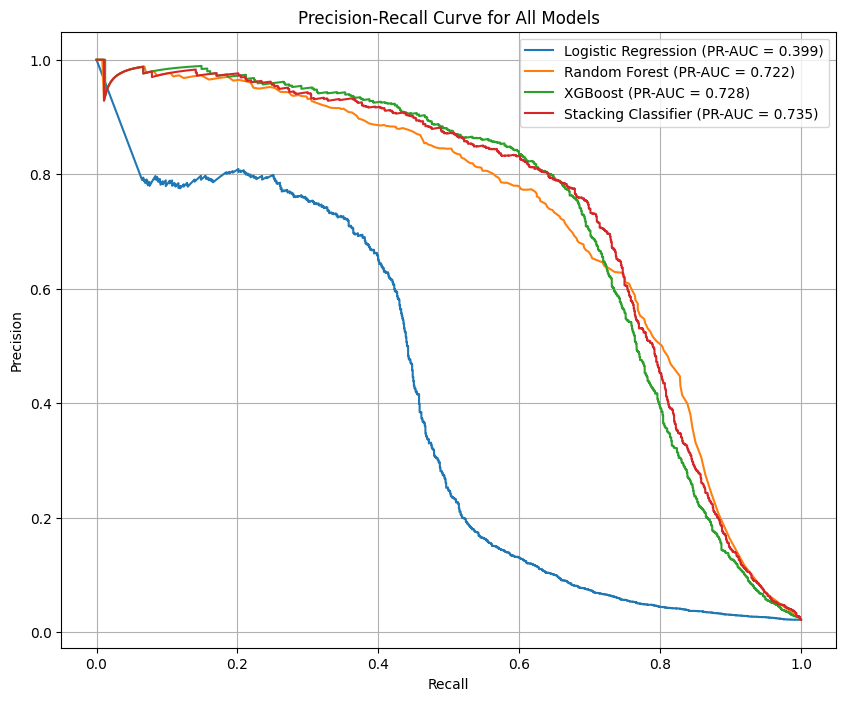

In [5]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, precision_recall_curve,
    auc, recall_score, precision_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier # <-- Import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline # <-- Import Pipeline

# Load and clean data
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- NEW: Define the Stacking Classifier ---

# 1. Create a pipeline for Logistic Regression to handle scaling internally
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# 2. Define the list of base estimators for the stack
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')),
    ('xgboost', XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))),
    ('logreg_pipe', lr_pipe) # Use the pipeline here
]

# 3. Define the final meta-model
final_estimator = LogisticRegression(max_iter=1000)

# 4. Create the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=5 # Use cross-validation to generate predictions for the meta-model
)

# --- Define models, now including the Stacking Classifier ---
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced'
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced'
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    ),
    "Stacking Classifier": stacking_clf # <-- Add the new model
}

# --- Lists to store results ---
results = []
plot_data = []

# --- Loop, Train, and Evaluate (NO CHANGES NEEDED HERE) ---
for name, model in models.items():
    print(f"=== {name} ===")

    # Handle scaling for the standalone Logistic Regression
    if name == "Logistic Regression":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # The Stacking Classifier will handle its own internal scaling via the pipeline
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Store results for summary table
    results.append({
        "Model": name,
        "F2-Score": fbeta_score(y_test, y_pred, beta=2),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred)
    })

    # Store data for the combined PR Curve plot
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plot_data.append({
        'model_name': name,
        'recall': recall,
        'precision': precision,
        'pr_auc': auc(recall, precision)
    })

# --- Create Summary Table from Loop Results ---
summary_df = pl.DataFrame(results).sort("F2-Score", descending=True)
print("\n--- Model Performance Summary ---")
print(summary_df)

# --- Plot Combined Precision-Recall Curve ---
plt.figure(figsize=(10, 8))
for data in plot_data:
    plt.plot(
        data['recall'],
        data['precision'],
        label=f"{data['model_name']} (PR-AUC = {data['pr_auc']:.3f})"
    )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Models')
plt.legend()
plt.grid(True)
plt.show()

Load & clean: 0.43s
Splits (group-aware): 0.11s
[FAST TUNER] Best val PR-AUC: 0.7434
[FAST TUNER] Params: {'n_estimators': 799, 'learning_rate': 0.08, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'tree_method': 'hist', 'n_jobs': -1, 'random_state': 42, 'eval_metric': 'aucpr', 'scale_pos_weight': 44.38917262512768, 'min_child_weight': 2, 'reg_lambda': 1, 'gamma': 0, 'max_delta_step': 2}
Tune XGB (fast grid): 149.13s
OOF stacking (3-fold): 37.61s


/Users/nazri/Project Harddrive/.venv/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Full-train + Calibrate + Threshold: 19.01s

--- FAST MODE: Model Performance ---
F2(test): 0.7401 | PR-AUC(test): 0.7601 | Recall@P≥90%(test): 0.4505
Confusion @thr=0.0828 -> TN=53930 FP=394 FN=304 TP=917
Test evaluation: 0.21s


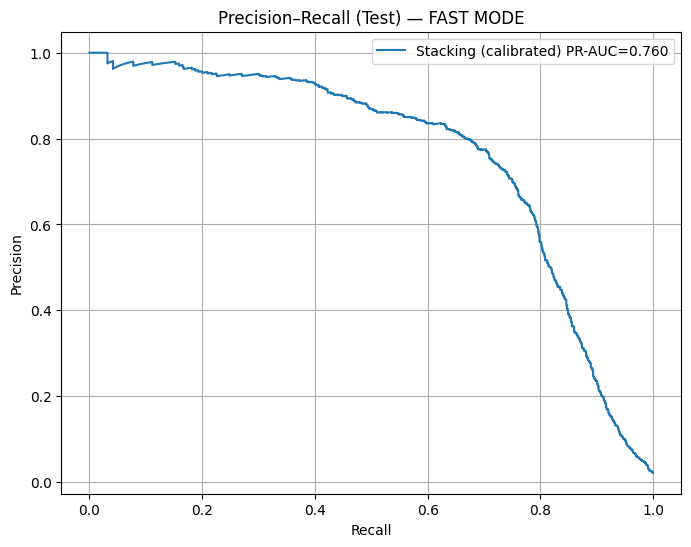

In [6]:
# FAST MODE: quick iteration pipeline for HDD failure modeling

# Optional:
# !pip install polars pandas scikit-learn xgboost matplotlib numpy

import warnings, time, os
warnings.filterwarnings("ignore", category=UserWarning)

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc, fbeta_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
import xgboost as xgb

# ==============================
# Fast-mode knobs
# ==============================
RANDOM_STATE   = 42
TEST_SIZE      = 0.20
VAL_SIZE       = 0.20
MIN_PRECISION  = 0.90

# Speed-ups:
N_FOLDS        = 3                # smaller OOF CV
XGB_ES_ROUNDS  = 50               # earlier stop
BASE_TREES     = 800              # lower cap for fast fit
USE_GPU        = bool(int(os.getenv("XGB_USE_GPU", "0")))  # set env var to 1 to use GPU
MAX_ROWS       = int(os.getenv("FAST_MAX_ROWS", "0"))      # cap rows for dry runs; 0 disables
SEQ_PARQUET    = "hdd_sequences_efficient.parquet"

def tic():
    return time.perf_counter()

def log_time(label, t0):
    print(f"{label}: {time.perf_counter() - t0:.2f}s")

# ==============================
# Metrics helpers
# ==============================
def best_fbeta_threshold(y_true, y_proba, beta=2.0):
    p, r, t = precision_recall_curve(y_true, y_proba)
    if len(t) == 0:
        return 0.5, 0.0
    f = (1 + beta**2) * (p[:-1] * r[:-1]) / (beta**2 * p[:-1] + r[:-1] + 1e-12)
    i = np.nanargmax(f)
    return float(t[i]), float(f[i])

def recall_at_precision(y_true, y_proba, min_precision=0.90):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    mask = p[:-1] >= min_precision
    return float(r[:-1][mask].max()) if mask.any() else 0.0

def pr_auc(y_true, y_proba):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    return float(auc(r, p))

# ==============================
# Version-robust XGB early stopping
# ==============================
def _predict_booster(booster, dmat):
    best_iter = getattr(booster, "best_iteration", None)
    if best_iter is not None:
        return booster.predict(dmat, iteration_range=(0, best_iter + 1))
    best_ntree = getattr(booster, "best_ntree_limit", None)
    try:
        if best_ntree is not None:
            return booster.predict(dmat, ntree_limit=best_ntree)
    except TypeError:
        pass
    return booster.predict(dmat)

def _fit_xgb_es(model, X_tr, y_tr, X_val, y_val, rounds=XGB_ES_ROUNDS):
    # 1) callbacks
    try:
        cb = [xgb.callback.EarlyStopping(rounds=rounds, metric_name="aucpr",
                                         save_best=True, maximize=True)]
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=cb, verbose=False)
        yv = model.predict_proba(X_val)[:, 1]
        best_trees = getattr(model, "best_iteration_", None)
        if best_trees is None:
            try:
                best_trees = model.get_booster().best_ntree_limit
            except Exception:
                best_trees = None
        return (lambda X: model.predict_proba(X)[:, 1]), model, best_trees, pr_auc(y_val, yv)
    except TypeError:
        pass
    except Exception:
        pass
    # 2) kwarg
    try:
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=rounds, verbose=False)
        yv = model.predict_proba(X_val)[:, 1]
        best_trees = getattr(model, "best_iteration_", None)
        if best_trees is None:
            try:
                best_trees = model.get_booster().best_ntree_limit
            except Exception:
                best_trees = None
        return (lambda X: model.predict_proba(X)[:, 1]), model, best_trees, pr_auc(y_val, yv)
    except TypeError:
        pass
    except Exception:
        pass
    # 3) native booster
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)
    params = model.get_params(deep=True)
    num_boost_round = int(params.get("n_estimators", BASE_TREES))
    train_params = {
        "objective": "binary:logistic",
        "learning_rate": params.get("learning_rate", 0.05),
        "max_depth": params.get("max_depth", 5),
        "subsample": params.get("subsample", 0.9),
        "colsample_bytree": params.get("colsample_bytree", 0.9),
        "tree_method": params.get("tree_method", "hist"),
        "eval_metric": "aucpr",
        "seed": params.get("random_state", 42),
        "scale_pos_weight": params.get("scale_pos_weight", 1.0),
        "max_delta_step": params.get("max_delta_step", 0),
        "gamma": params.get("gamma", 0),
        "min_child_weight": params.get("min_child_weight", 1),
        "reg_lambda": params.get("reg_lambda", 1.0),
    }
    booster = xgb.train(
        train_params, dtrain, num_boost_round=num_boost_round,
        evals=[(dval, "validation")], early_stopping_rounds=rounds, verbose_eval=False
    )
    def predict_proba_native(X):
        return _predict_booster(booster, xgb.DMatrix(X))
    yv = predict_proba_native(X_val)
    best_iter = getattr(booster, "best_iteration", None)
    best_ntree = getattr(booster, "best_ntree_limit", None)
    best_trees = int(best_iter) if best_iter is not None else (int(best_ntree) if best_ntree is not None else None)
    return predict_proba_native, booster, best_trees, pr_auc(y_val, yv)

def _pos_weight(y_vec):
    pos = int((y_vec == 1).sum()); neg = int((y_vec == 0).sum())
    return (neg / max(1, pos)) if pos > 0 else 1.0

# ==============================
# Tiny XGB tuner (FAST GRID)
# ==============================
def tune_xgb_fast(X_tr, y_tr, X_val, y_val, use_gpu=USE_GPU):
    base = dict(
        n_estimators=BASE_TREES, learning_rate=0.08, max_depth=5,
        subsample=0.9, colsample_bytree=0.9,
        tree_method="gpu_hist" if use_gpu else "hist",
        n_jobs=-1, random_state=RANDOM_STATE, eval_metric="aucpr",
        scale_pos_weight=_pos_weight(y_tr),
        # regularization defaults light; fast to try
    )
    grid = dict(
        max_depth=[4,5],
        min_child_weight=[2,6],
        reg_lambda=[1,5],
        subsample=[0.9],
        colsample_bytree=[0.8,0.9],
        gamma=[0],
        max_delta_step=[0,2],
    )
    best = {"score": -np.inf, "params": None, "best_trees": None}
    import itertools
    keys = list(grid.keys())
    for vals in itertools.product(*[grid[k] for k in keys]):
        params = base.copy()
        params.update({k: v for k, v in zip(keys, vals)})
        model = XGBClassifier(**params)
        _, _, best_trees, val_score = _fit_xgb_es(model, X_tr, y_tr, X_val, y_val)
        if val_score > best["score"]:
            best = {"score": val_score, "params": params, "best_trees": best_trees}
    final_params = best["params"].copy()
    if best["best_trees"] is not None:
        final_params["n_estimators"] = int(best["best_trees"])
    return final_params, best["score"]

# ==============================
# LOAD & CLEAN
# ==============================
t0 = tic()
df_seq = pl.read_parquet(SEQ_PARQUET).drop_nulls(subset=["failure"])

if MAX_ROWS > 0 and df_seq.height > MAX_ROWS:
    df_seq = df_seq.sample(n=MAX_ROWS, shuffle=True, seed=RANDOM_STATE)

X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = [n for n, dt in X_pl.schema.items() if dt in (pl.Float32, pl.Float64)]
X_pl = (
    X_pl
    .fill_null(0)
    .with_columns([pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
                   for c in float_cols])
)
X = X_pl.to_pandas().apply(pd.to_numeric, errors="coerce").fillna(0)
y = df_seq["failure"].to_pandas().astype(int)
groups_all = df_seq["serial_number"].to_pandas()
log_time("Load & clean", t0)

# ==============================
# SPLITS (group-aware)
# ==============================
t0 = tic()
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups_all))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_tr_all = groups_all.iloc[train_idx]

gss_val = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
tr_idx, val_idx = next(gss_val.split(X_train, y_train, groups=groups_tr_all))
X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
log_time("Splits (group-aware)", t0)

# ==============================
# TUNE XGB (FAST)
# ==============================
t0 = tic()
xgb_params, xgb_val_auc = tune_xgb_fast(X_tr, y_tr, X_val, y_val)
print(f"[FAST TUNER] Best val PR-AUC: {xgb_val_auc:.4f}")
print(f"[FAST TUNER] Params: {xgb_params}")
log_time("Tune XGB (fast grid)", t0)

def _pos_weight_vec(y_vec):
    pos = int((y_vec == 1).sum()); neg = int((y_vec == 0).sum())
    return (neg / max(1, pos)) if pos > 0 else 1.0

def make_xgb_final_for(y_vec, base_params):
    p = base_params.copy()
    p["scale_pos_weight"] = _pos_weight_vec(y_vec)
    return XGBClassifier(**p)

# ==============================
# OOF STACKING (FAST: 3 folds)
# ==============================
t0 = tic()
gkf = GroupKFold(n_splits=N_FOLDS)
oof_meta = np.zeros((len(X_train), 3), dtype=np.float64)  # [rf, xgb, lr]

rf_base = RandomForestClassifier(
    n_estimators=250, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
)

for fold, (tr_f_idx, va_f_idx) in enumerate(gkf.split(X_train, y_train, groups=groups_tr_all), start=1):
    X_tr_f, X_va_f = X_train.iloc[tr_f_idx], X_train.iloc[va_f_idx]
    y_tr_f, y_va_f = y_train.iloc[tr_f_idx], y_train.iloc[va_f_idx]

    rf_f  = RandomForestClassifier(**rf_base.get_params()).fit(X_tr_f, y_tr_f)
    xgb_f = make_xgb_final_for(y_tr_f, xgb_params).fit(X_tr_f, y_tr_f)
    lr_f  = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=800, class_weight="balanced", random_state=RANDOM_STATE))
    ]).fit(X_tr_f, y_tr_f)

    oof_meta[va_f_idx, 0] = rf_f.predict_proba(X_va_f)[:, 1]
    oof_meta[va_f_idx, 1] = xgb_f.predict_proba(X_va_f)[:, 1]
    oof_meta[va_f_idx, 2] = lr_f.predict_proba(X_va_f)[:, 1]

log_time("OOF stacking (3-fold)", t0)

# Meta-learner
meta = LogisticRegression(max_iter=800, class_weight="balanced", random_state=RANDOM_STATE)
meta.fit(oof_meta, y_train)

# ==============================
# FULL-TRAIN BASES + CALIBRATION + THRESHOLD
# ==============================
t0 = tic()
rf_full  = RandomForestClassifier(**rf_base.get_params()).fit(X_train, y_train)
xgb_full = make_xgb_final_for(y_train, xgb_params).fit(X_train, y_train)
lr_full  = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=800, class_weight="balanced", random_state=RANDOM_STATE))
]).fit(X_train, y_train)

val_meta = np.column_stack([
    rf_full.predict_proba(X_val)[:, 1],
    xgb_full.predict_proba(X_val)[:, 1],
    lr_full.predict_proba(X_val)[:, 1],
])

# Calibrate meta on validation (Platt)
meta_cal = CalibratedClassifierCV(meta, method="sigmoid", cv="prefit")
meta_cal.fit(val_meta, y_val)
val_meta_proba_cal = meta_cal.predict_proba(val_meta)[:, 1]
thr, _ = best_fbeta_threshold(y_val, val_meta_proba_cal, beta=2.0)
log_time("Full-train + Calibrate + Threshold", t0)

# ==============================
# TEST EVAL
# ==============================
t0 = tic()
test_meta = np.column_stack([
    rf_full.predict_proba(X_test)[:, 1],
    xgb_full.predict_proba(X_test)[:, 1],
    lr_full.predict_proba(X_test)[:, 1],
])
test_proba_cal = meta_cal.predict_proba(test_meta)[:, 1]
test_pred_cal  = (test_proba_cal >= thr).astype(int)

f2_test   = fbeta_score(y_test, test_pred_cal, beta=2.0)
ap_test   = pr_auc(y_test, test_proba_cal)
rec_p90   = recall_at_precision(y_test, test_proba_cal, min_precision=MIN_PRECISION)
cm        = confusion_matrix(y_test, test_pred_cal)

print("\n--- FAST MODE: Model Performance ---")
print(f"F2(test): {f2_test:.4f} | PR-AUC(test): {ap_test:.4f} | Recall@P≥{int(MIN_PRECISION*100)}%(test): {rec_p90:.4f}")
print(f"Confusion @thr={thr:.4f} -> TN={cm[0,0]} FP={cm[0,1]} FN={cm[1,0]} TP={cm[1,1]}")
log_time("Test evaluation", t0)

# ==============================
# PR CURVE (quick)
# ==============================
plt.figure(figsize=(8,6))
p, r, _ = precision_recall_curve(y_test, test_proba_cal)
plt.plot(r, p, label=f"Stacking (calibrated) PR-AUC={ap_test:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (Test) — FAST MODE")
plt.grid(True); plt.legend(); plt.show()


=== Logistic Regression ===
=== Random Forest ===
=== XGBoost ===
=== Stacking Classifier ===

--- Model Performance Summary ---
shape: (4, 3)
┌─────────────────────┬───────────────┬────────────────┐
│ Model               ┆ Test F2-Score ┆ Train F2-Score │
│ ---                 ┆ ---           ┆ ---            │
│ str                 ┆ f64           ┆ f64            │
╞═════════════════════╪═══════════════╪════════════════╡
│ XGBoost             ┆ 0.690872      ┆ 0.894011       │
│ Stacking Classifier ┆ 0.667802      ┆ 0.97529        │
│ Random Forest       ┆ 0.573944      ┆ 1.0            │
│ Logistic Regression ┆ 0.393496      ┆ 0.390647       │
└─────────────────────┴───────────────┴────────────────┘


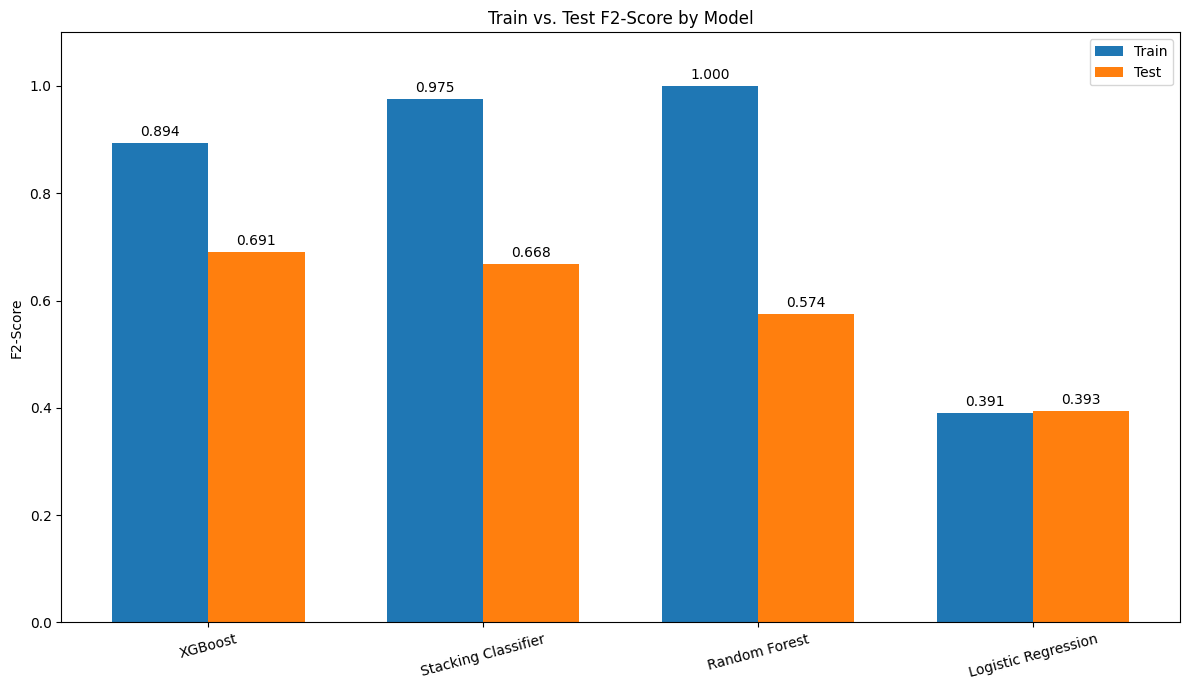

In [7]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # <-- Import NumPy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, precision_recall_curve,
    auc, recall_score, precision_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Load and clean data
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models and Stacking Classifier
lr_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))])
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')),
    ('xgboost', XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))),
    ('logreg_pipe', lr_pipe)
]
final_estimator = LogisticRegression(max_iter=1000)
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])),
    "Stacking Classifier": stacking_clf
}

# List to store results
results = []

# --- Loop, Train, and Evaluate ---
for name, model in models.items():
    print(f"=== {name} ===")

    if name == "Logistic Regression":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred_test = model.predict(X_test_scaled)
        y_pred_train = model.predict(X_train_scaled) # <-- Predict on train set
    else:
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train) # <-- Predict on train set

    # Calculate metrics for both test and train sets
    f2_test = fbeta_score(y_test, y_pred_test, beta=2)
    f2_train = fbeta_score(y_train, y_pred_train, beta=2) # <-- Calculate train score

    # Store results
    results.append({
        "Model": name,
        "Test F2-Score": f2_test,
        "Train F2-Score": f2_train
    })

# --- Create Summary Table from Loop Results ---
summary_df = pl.DataFrame(results).sort("Test F2-Score", descending=True)
print("\n--- Model Performance Summary ---")
print(summary_df)

# --- Plot Train vs. Test Scores ---
model_names = summary_df["Model"].to_numpy()
test_scores = summary_df["Test F2-Score"].to_numpy()
train_scores = summary_df["Train F2-Score"].to_numpy()

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('F2-Score')
ax.set_title('Train vs. Test F2-Score by Model')
ax.set_xticks(x, model_names, rotation=15)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
ax.set_ylim(0, 1.1)
fig.tight_layout()
plt.show()


--- Fitting XGBoost with evaluation sets ---


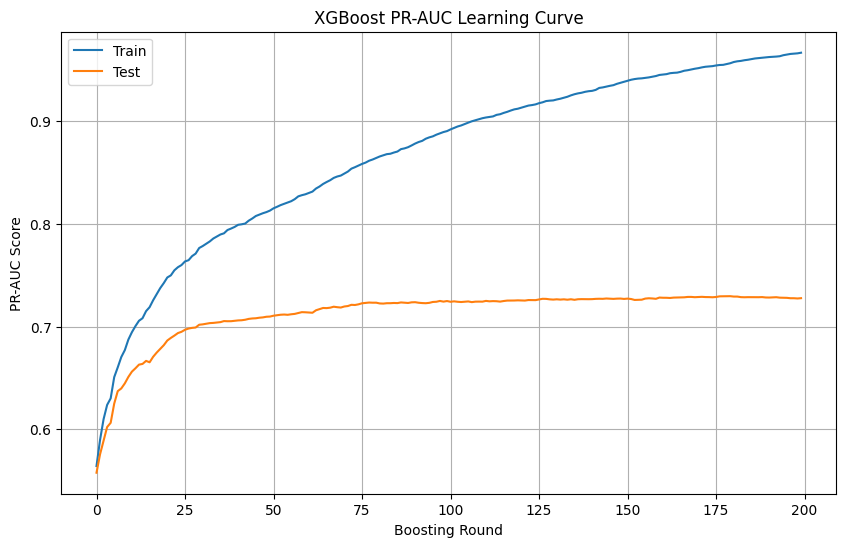

In [8]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, precision_recall_curve,
    auc, recall_score, precision_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Load and clean data
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- FIX 1: Add eval_metric to the XGBoost constructor ---
xgb_params = {
    'n_estimators': 200,
    'tree_method': "hist",
    'n_jobs': -1,
    'random_state': 42,
    'scale_pos_weight': (y_train.value_counts()[0] / y_train.value_counts()[1]),
    'eval_metric': 'aucpr' # <-- Set the metric here
}

# Define models and Stacking Classifier
lr_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))])
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')),
    ('xgboost', XGBClassifier(**xgb_params)),
    ('logreg_pipe', lr_pipe)
]
final_estimator = LogisticRegression(max_iter=1000)
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(**xgb_params),
    "Stacking Classifier": stacking_clf
}

# (The main training loop and summary table generation would go here as before)
# ...

# --- Plotting XGBoost's Learning Curve ---

# Isolate the XGBoost model
xgb_model = models["XGBoost"]

# Define the evaluation sets
eval_set = [(X_train, y_train), (X_test, y_test)]

# --- FIX 2: Remove eval_metric from the .fit() call ---
print("\n--- Fitting XGBoost with evaluation sets ---")
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Retrieve the results
results = xgb_model.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)

# Plot the learning curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
plt.ylabel('PR-AUC Score')
plt.xlabel('Boosting Round')
plt.title('XGBoost PR-AUC Learning Curve')
plt.grid(True)
plt.show()

In [9]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV # <-- Import
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, make_scorer # <-- Import
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- Load and Clean Data ---
# (Assuming the previous data loading and cleaning steps are here)
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===================================================================
# --- NEW: HYPERPARAMETER TUNING SECTION ---
# ===================================================================

print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

# 1. Define the base XGBoost model to be tuned
# We use the original constructor without n_estimators, as it will be tuned
xgb_tune = XGBClassifier(
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='aucpr'
)

# 2. Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# 3. Create a custom scorer to optimize for the F2-score
f2_scorer = make_scorer(fbeta_score, beta=2)

# 4. Set up RandomizedSearchCV
# n_iter: number of parameter settings that are sampled (higher is better but slower)
# cv: number of cross-validation folds
random_search = RandomizedSearchCV(
    estimator=xgb_tune,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 different combinations
    scoring=f2_scorer,
    n_jobs=-1,
    cv=5,       # 5-fold cross-validation
    random_state=42,
    verbose=1   # Print progress
)

# 5. Run the search
random_search.fit(X_train, y_train)

# 6. Print the best results
print("\nBest Parameters found:", random_search.best_params_)
print("Best F2-Score on validation set:", f"{random_search.best_score_:.4f}")

# --- 7. Evaluate the BEST model on the hold-out test set ---
best_xgb_model = random_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)

print("\n--- Performance of Tuned XGBoost Model on Test Set ---")
print(classification_report(y_test, y_pred_best))
print(f"Final Test F2-Score: {fbeta_score(y_test, y_pred_best, beta=2):.4f}")


--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters found: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best F2-Score on validation set: 0.7123

--- Performance of Tuned XGBoost Model on Test Set ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     54324
           1       0.60      0.77      0.68      1221

    accuracy                           0.98     55545
   macro avg       0.80      0.88      0.83     55545
weighted avg       0.99      0.98      0.98     55545

Final Test F2-Score: 0.7319


In [18]:
from __future__ import annotations

from typing import Any, Dict, Optional
from inspect import signature

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import check_X_y, check_array
import xgboost as xgb
from xgboost import XGBClassifier


# ---- sklearn 1.6+ compatibility shims (force_all_finite -> ensure_all_finite) ----
def _check_X_y_compat(X, y):
    params = signature(check_X_y).parameters
    if "ensure_all_finite" in params:  # sklearn >= 1.6
        return check_X_y(X, y, accept_sparse=False, ensure_all_finite="allow-nan")
    else:  # sklearn < 1.6
        return check_X_y(X, y, accept_sparse=False, force_all_finite="allow-nan")


def _check_array_compat(X):
    params = signature(check_array).parameters
    if "ensure_all_finite" in params:  # sklearn >= 1.6
        return check_array(X, accept_sparse=False, ensure_all_finite="allow-nan")
    else:  # sklearn < 1.6
        return check_array(X, accept_sparse=False, force_all_finite="allow-nan")


class XGBWithES(BaseEstimator, ClassifierMixin):
    """
    Sklearn-compatible XGBoost wrapper that does *internal* early stopping.

    - Splits the provided training fold into (train_inner / es_val_inner).
    - Tries the sklearn API with callbacks first; falls back to the native booster if needed.
    - Works with GridSearchCV / RandomizedSearchCV / pipelines.
    - Supports sample_weight.
    - Exposes underlying fitted model via .fitted_ (XGBClassifier or Booster).

    Parameters
    ----------
    es_val_size : float
        Fraction for the internal early-stopping validation split.
    es_rounds : int
        Early stopping rounds/patience.
    random_state : int
        Random seed used for the inner split and passed to XGBoost.
    n_jobs : int
        Parallelism for XGBoost.
    threshold : float
        Decision threshold for predict().
    **xgb_params :
        Any XGBClassifier parameters (or XGBoost training params for fallback).

    Notes
    -----
    - Default is binary classification with eval_metric='aucpr'.
      For multiclass, pass objective='multi:softprob', eval_metric='mlogloss', etc.
    """

    def __init__(
        self,
        es_val_size: float = 0.15,
        es_rounds: int = 50,
        random_state: int = 42,
        n_jobs: int = 1,
        threshold: float = 0.5,
        **xgb_params: Any,
    ):
        self.es_val_size = es_val_size
        self.es_rounds = es_rounds
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.threshold = threshold
        self.xgb_params = xgb_params

        # set during fit
        self.fitted_: Optional[Any] = None
        self._predict_proba_fn = None

    # ---- sklearn plumbing ----
    def get_params(self, deep: bool = True) -> Dict[str, Any]:
        return {
            "es_val_size": self.es_val_size,
            "es_rounds": self.es_rounds,
            "random_state": self.random_state,
            "n_jobs": self.n_jobs,
            "threshold": self.threshold,
            **self.xgb_params,
        }

    def set_params(self, **params):
        for k in ["es_val_size", "es_rounds", "random_state", "n_jobs", "threshold"]:
            if k in params:
                setattr(self, k, params.pop(k))
        self.xgb_params.update(params)
        return self

    # ---- core logic ----
    def _default_params(self) -> Dict[str, Any]:
        p = dict(self.xgb_params)  # copy
        p.setdefault("n_estimators", 800)
        p.setdefault("learning_rate", 0.05)
        p.setdefault("max_depth", 5)
        p.setdefault("subsample", 0.9)
        p.setdefault("colsample_bytree", 0.9)
        p.setdefault("tree_method", "hist")
        p.setdefault("n_jobs", self.n_jobs)
        p.setdefault("random_state", self.random_state)
        p.setdefault("eval_metric", self.xgb_params.get("eval_metric", "aucpr"))
        return p

    def fit(self, X, y, sample_weight: Optional[np.ndarray] = None):
        # Validate & store metadata
        X, y = _check_X_y_compat(X, y)
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = getattr(X, "columns", None)
        self.classes_ = np.unique(y)

        target_type = type_of_target(y)
        if target_type not in {"binary", "multiclass"}:
            raise ValueError(f"Unsupported target type: {target_type}")

        # Internal stratified split (only if we have >= 2 classes and enough data)
        do_split = (len(self.classes_) > 1) and (len(y) > 10) and (0 < self.es_val_size < 0.5)
        if do_split:
            X_tr, X_es, y_tr, y_es, sw_tr, sw_es = train_test_split(
                X,
                y,
                sample_weight if sample_weight is not None else np.ones(len(y)),
                test_size=self.es_val_size,
                stratify=y,
                random_state=self.random_state,
            )
        else:
            X_tr, y_tr = X, y
            X_es, y_es = X, y
            sw_tr = sample_weight
            sw_es = sample_weight

        # Guard single-class eval set in binary
        if len(np.unique(y_es)) < 2 and target_type == "binary":
            X_tr, y_tr = X, y
            X_es, y_es = X, y
            sw_tr = sample_weight
            sw_es = sample_weight

        params = self._default_params()

        # ---- Preferred path: sklearn API with callbacks ----
        clf = XGBClassifier(**params)
        try:
            callbacks = [
                xgb.callback.EarlyStopping(
                    rounds=int(self.es_rounds),
                    metric_name=params.get("eval_metric", "aucpr"),
                    save_best=True,
                    maximize=params.get("eval_metric", "aucpr") in {"auc", "aucpr"},
                )
            ]
            fit_kwargs = {
                "eval_set": [(X_es, y_es)],
                "callbacks": callbacks,
                "verbose": False,
            }
            if sw_tr is not None:
                fit_kwargs["sample_weight"] = sw_tr
            # eval_sample_weight is supported only in newer xgboost
            try:
                if sw_es is not None:
                    fit_kwargs["eval_sample_weight"] = [sw_es]
            except TypeError:
                fit_kwargs.pop("eval_sample_weight", None)

            clf.fit(X_tr, y_tr, **fit_kwargs)
            self.fitted_ = clf

            def _predict_proba(Xq):
                return clf.predict_proba(Xq)

            self._predict_proba_fn = _predict_proba
            return self

        except TypeError:
            pass  # fall back
        except Exception:
            pass  # conservative fallback

        # ---- Fallback: native Booster API (always works) ----
        dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sw_tr)
        dval = xgb.DMatrix(X_es, label=y_es, weight=sw_es)

        booster_params = {
            "objective": "binary:logistic" if target_type == "binary" else "multi:softprob",
            "num_class": int(len(self.classes_)) if target_type == "multiclass" else None,
            "learning_rate": params.get("learning_rate"),
            "max_depth": params.get("max_depth"),
            "subsample": params.get("subsample"),
            "colsample_bytree": params.get("colsample_bytree"),
            "tree_method": params.get("tree_method"),
            "eval_metric": params.get("eval_metric", "aucpr" if target_type == "binary" else "mlogloss"),
            "seed": params.get("random_state"),
            "scale_pos_weight": params.get("scale_pos_weight", 1.0),
            "min_child_weight": params.get("min_child_weight", 1),
            "gamma": params.get("gamma", 0),
            "reg_lambda": params.get("reg_lambda", 1.0),
            "max_delta_step": params.get("max_delta_step", 0),
            "nthread": params.get("n_jobs", self.n_jobs),
        }
        booster_params = {k: v for k, v in booster_params.items() if v is not None}

        booster = xgb.train(
            params=booster_params,
            dtrain=dtrain,
            num_boost_round=int(params.get("n_estimators")),
            evals=[(dval, "validation")],
            early_stopping_rounds=int(self.es_rounds),
            verbose_eval=False,
        )

        self.fitted_ = booster

        def _predict_proba_booster(Xq):
            dm = xgb.DMatrix(Xq)
            bi = getattr(booster, "best_iteration", None)
            if bi is not None:
                proba = booster.predict(dm, iteration_range=(0, bi + 1))
            else:
                bnt = getattr(booster, "best_ntree_limit", None)
                if bnt is not None:
                    try:
                        proba = booster.predict(dm, ntree_limit=bnt)
                    except TypeError:
                        proba = booster.predict(dm)
                else:
                    proba = booster.predict(dm)

            if target_type == "binary" and proba.ndim == 1:
                proba = np.column_stack([1.0 - proba, proba])
            return proba

        self._predict_proba_fn = _predict_proba_booster
        return self

    # ---- inference API ----
    def _ensure_fitted(self):
        if self._predict_proba_fn is None or self.fitted_ is None:
            raise AttributeError("Model is not fitted yet. Call .fit(X, y) first.")

    def predict_proba(self, X):
        self._ensure_fitted()
        X = _check_array_compat(X)
        proba = self._predict_proba_fn(X)

        # Align probability columns to self.classes_ (sklearn convention)
        if proba.shape[1] == len(self.classes_):
            # proba assumed already ordered by sorted classes; keep explicit behavior if needed
            return proba
        # Safety for odd edge cases
        if len(self.classes_) == 2 and proba.ndim == 1:
            proba = np.column_stack([1.0 - proba, proba])
        return proba

    def decision_function(self, X):
        proba = self.predict_proba(X)
        if proba.shape[1] == 2:
            p1 = proba[:, 1]
            eps = 1e-12
            return np.log(np.clip(p1, eps, 1 - eps) / np.clip(1 - p1, eps, 1 - eps))
        return proba  # multiclass: return probabilities as scores

    def predict(self, X):
        self._ensure_fitted()
        proba = self.predict_proba(X)
        if proba.shape[1] == 2:
            return (proba[:, 1] >= self.threshold).astype(self.classes_.dtype)
        idx = np.argmax(proba, axis=1)
        return self.classes_[idx]

    # convenience accessors
    def get_xgb_sklearn(self) -> Optional[XGBClassifier]:
        return self.fitted_ if isinstance(self.fitted_, XGBClassifier) else None

    def get_booster(self) -> Optional[xgb.Booster]:
        if isinstance(self.fitted_, XGBClassifier):
            return self.fitted_.get_booster()
        return self.fitted_


In [19]:
# 1) Plain fit
clf = XGBWithES(
    es_val_size=0.2, es_rounds=100, random_state=123, n_jobs=8,
    max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9
).fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# 2) In GridSearchCV (no leakage: early-stopping split is inside each fold)
from sklearn.model_selection import StratifiedKFold, GridSearchCV

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05],
    "n_estimators": [400, 800, 1200],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
search = GridSearchCV(
    XGBWithES(es_val_size=0.15, es_rounds=50, random_state=123, n_jobs=8),
    param_grid=param_grid,
    scoring="average_precision",  # 'roc_auc' also common
    cv=cv,
    n_jobs=1,  # let xgboost handle parallelism via n_jobs
    refit=True,
)
search.fit(X, y)
best_model = search.best_estimator_


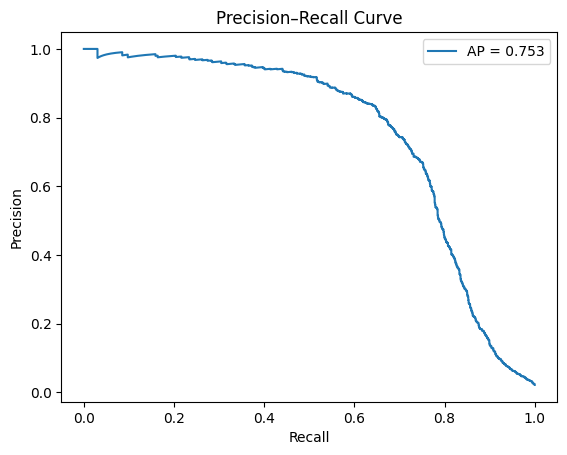

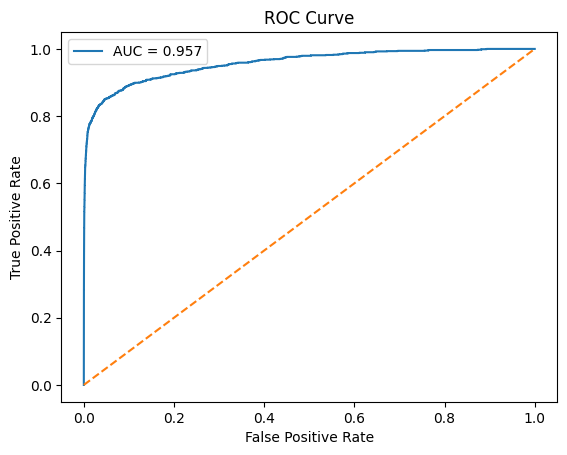

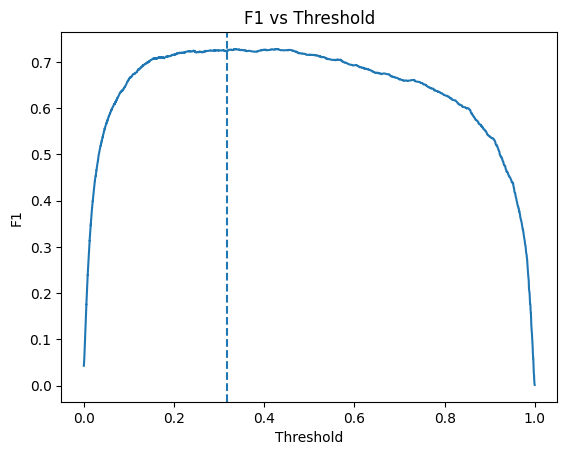

<Figure size 640x480 with 0 Axes>

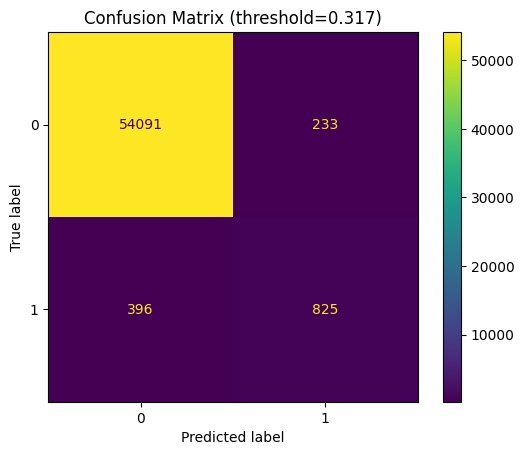

<Figure size 640x480 with 0 Axes>

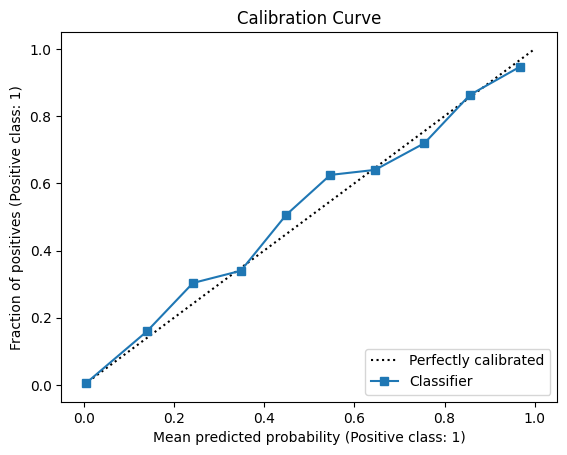

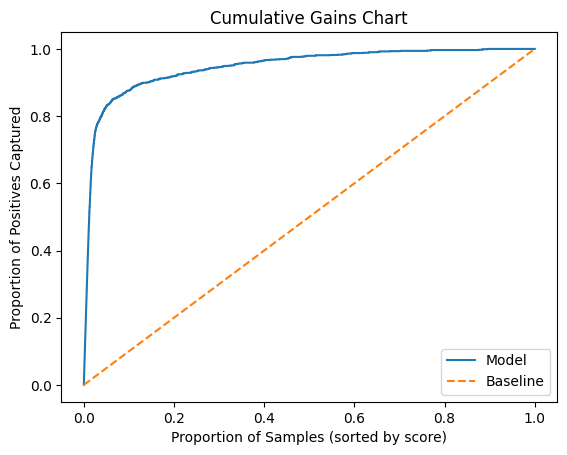

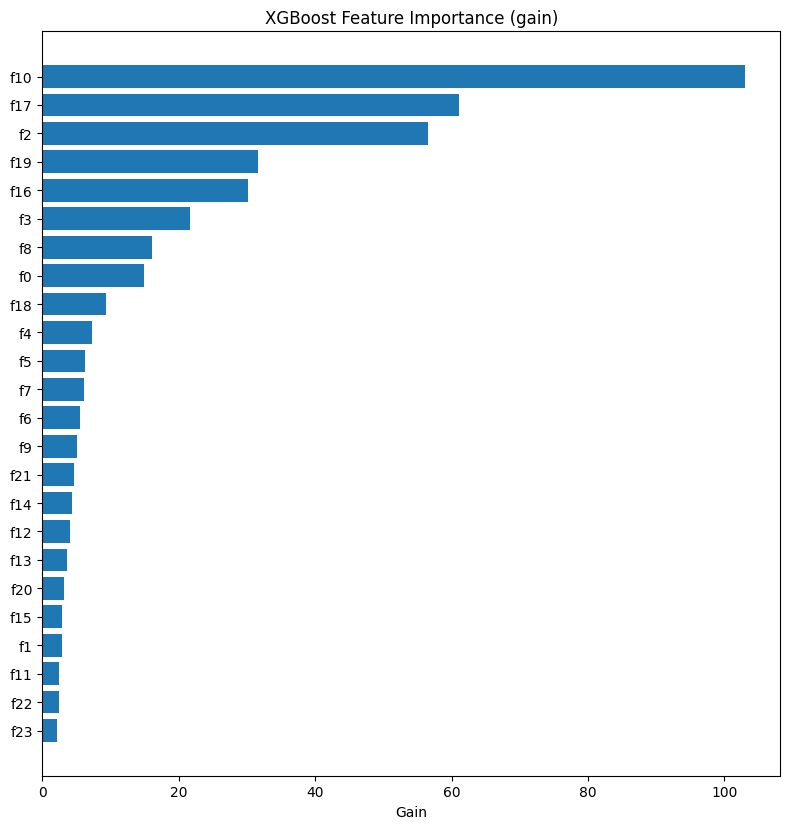

{'binary': True,
 'average_precision': 0.7527934155296006,
 'roc_auc': 0.9574070124103259,
 'tuned_threshold': 0.316972941160202,
 'tuned_threshold_f1': 0.8380281690135873}

In [24]:
# Plain fit visualization
metrics_plain = report_viz(
    estimator=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)
metrics_plain


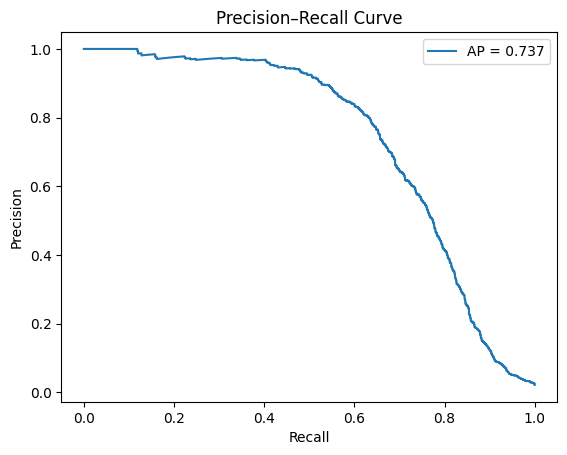

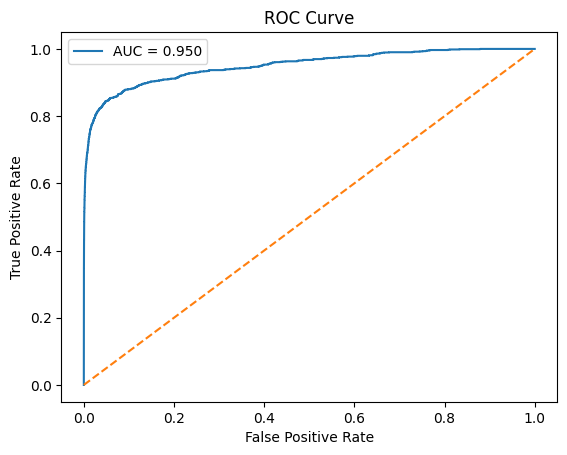

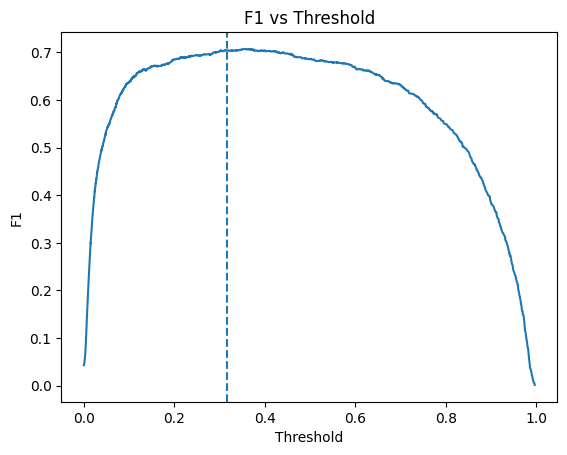

<Figure size 640x480 with 0 Axes>

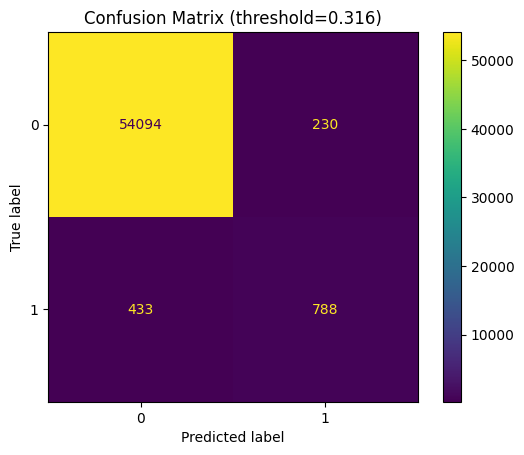

<Figure size 640x480 with 0 Axes>

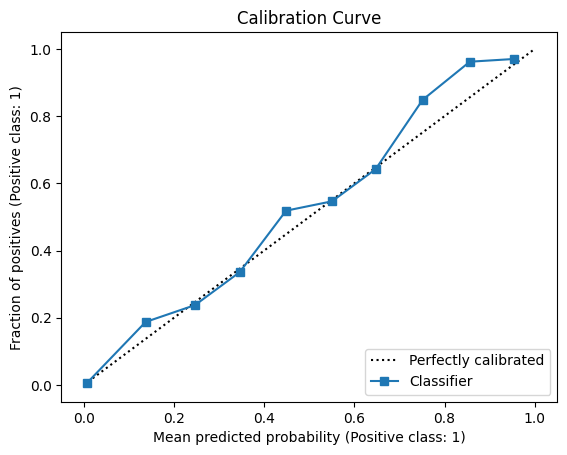

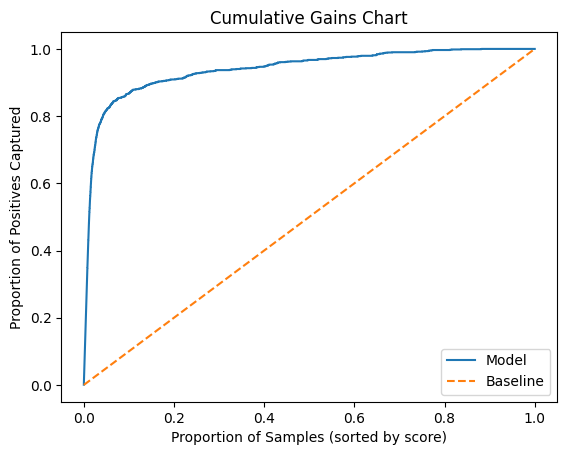

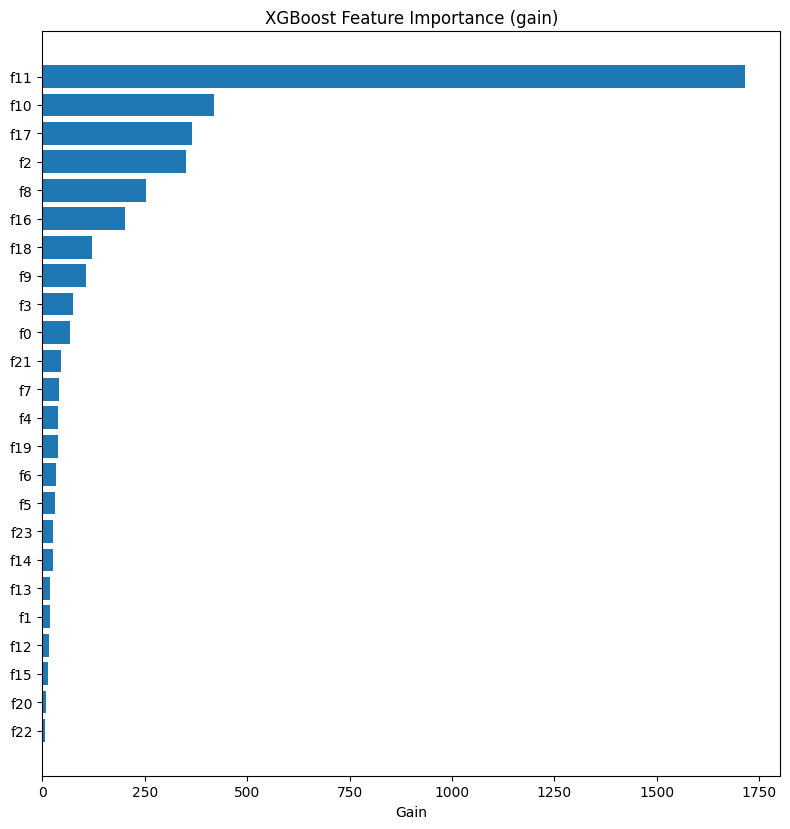

{'binary': True,
 'average_precision': 0.7372226100869351,
 'roc_auc': 0.9498537033328286,
 'tuned_threshold': 0.31645089387893677,
 'tuned_threshold_f1': 0.7029625489095098}

In [25]:
metrics_gs = report_viz(
    estimator=best_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)
metrics_gs


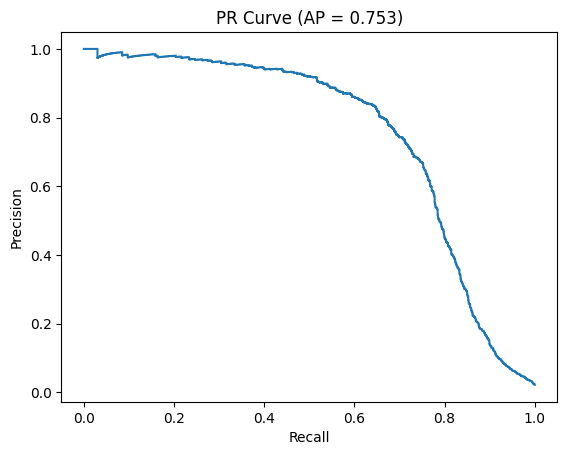

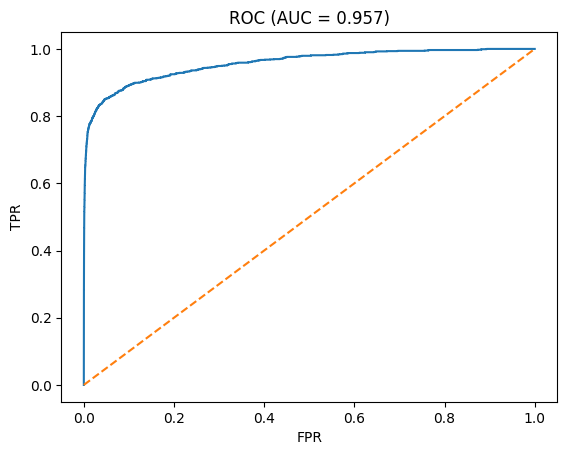

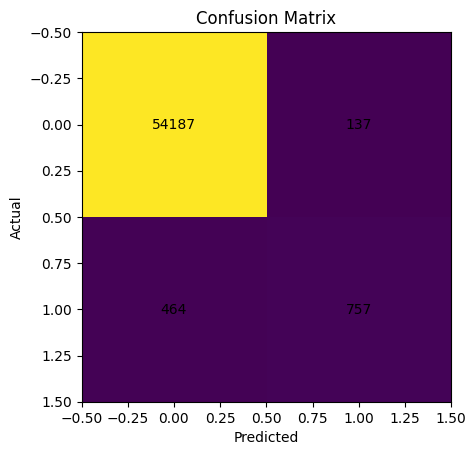

In [26]:
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt

# 1) Precision–Recall
prec, rec, thr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure()
plt.step(rec, prec, where="post")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve (AP = {ap:.3f})")
plt.show()

# 2) ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()

# 3) Confusion Matrix (using your predicted labels)
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()
